YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


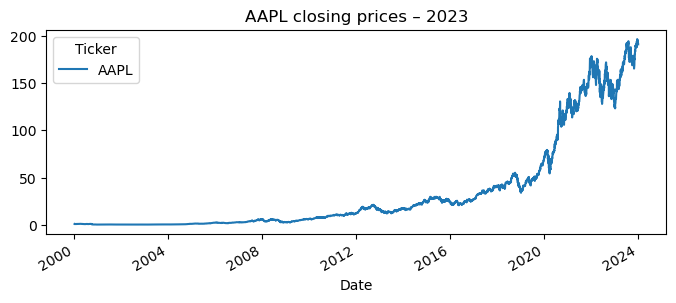

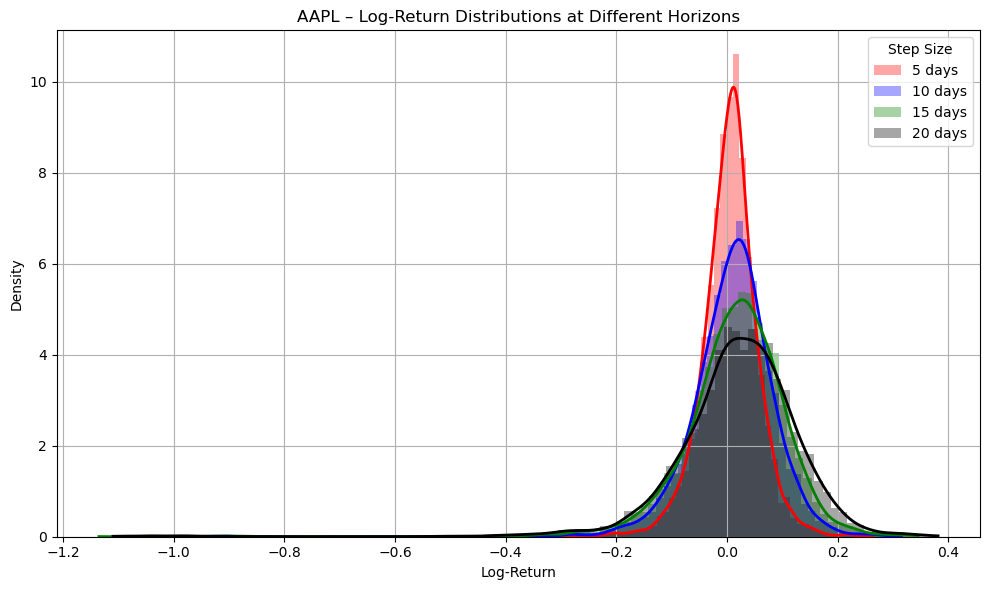

In [2]:
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

ticker = "AAPL"
prices = yf.download(ticker, start="2000-01-01", end="2023-12-31")["Close"].dropna()
prices.plot(title=f"{ticker} closing prices – 2023", figsize=(8,3))
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

two_week_steps_list = [5, 10, 15, 20]  # trading-day lags
colors = ["red", "blue", "green", "black"]

plt.figure(figsize=(10, 6))

for i, step in enumerate(two_week_steps_list):
    log_returns = np.log(prices / prices.shift(step)).dropna().values
    
    plt.hist(
        log_returns,
        bins=100,
        density=True,
        color=colors[i],
        alpha=0.35,
        label=f"{step} days",
        edgecolor='none'
    )
    
    kde = gaussian_kde(log_returns.reshape(1, -1))
    x_vals = np.linspace(log_returns.min(), log_returns.max(), 1000)
    plt.plot(x_vals, kde(x_vals), color=colors[i], linewidth=2)

plt.title(f"{ticker} – Log-Return Distributions at Different Horizons")
plt.xlabel("Log-Return")
plt.ylabel("Density")
plt.legend(title="Step Size")
plt.grid(True)
plt.tight_layout()
plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


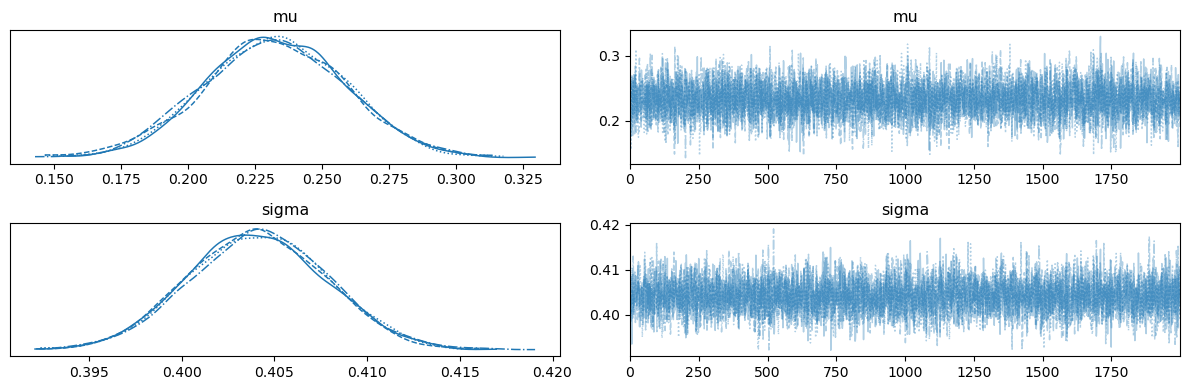

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.2324,0.0261,0.1852,0.2825,0.0004,0.0003,5086.1381,4930.7503,1.0000
sigma,0.4041,0.0037,0.3972,0.4111,0.0001,0.0000,4912.5993,4697.9496,1.0007


In [3]:
two_week_steps = 10
dt = two_week_steps/252

biweek_log_returns = np.log(prices / prices.shift(two_week_steps)).dropna().values

with pm.Model() as gbm_model:
    mu     = pm.Normal("mu", mu=0.0, sigma=10)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=10)            # volatility (per √year)

    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = biweek_log_returns
    )

    trace = pm.sample(
        draws         = 2000,
        tune          = 2000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)
